<a href="https://colab.research.google.com/github/r-yv/coding-exercise/blob/main/part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset sample (price, square_footage, location):
   square_footage  location    price
0       3239.9339  Downtown  3292639
1       2884.7252  Downtown  3402796
2       1334.7236  Downtown  1034532
3        667.3618     Rural   490916
4       1700.6962     Rural  1500526 

District → Location bucket mapping used in this script:
  Downtown: ['Al Yasmin', 'Al Rawdah', 'South Riyadh', 'Al Sulimaniyah']
  Suburb:   ['West Riyadh', 'Al Malqa', 'Al Narjis', 'East Riyadh']
  Rural:    ['North Riyadh', 'King Fahd', 'Olaya', 'Al Qirawan']

Predicted price for a 2000 sq ft house in Downtown: 1,900,147.25 SAR

Model Coefficients:
Intercept: 126,402.71
location_Suburb: -179,817.47
location_Rural: -378,954.15
square_footage: 886.87

Explanation:
- Square footage coefficient (886.87) means: increasing the house size by 1 sq ft changes the predicted price by about 886.87 SAR, on average, assuming location stays the same.
- Location is one-hot encoded with 'Downtown' as the baseline (because drop='fir

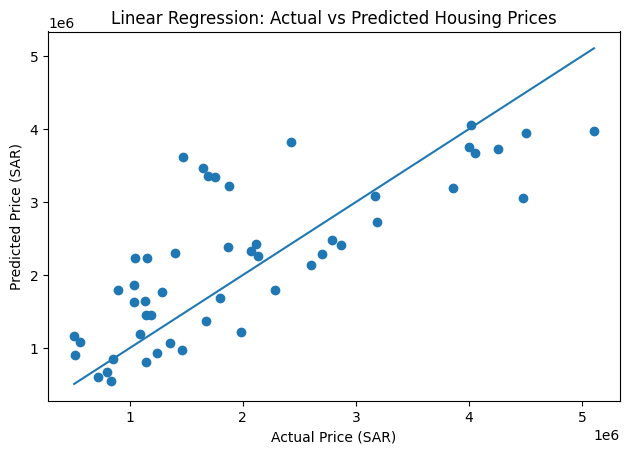

In [3]:
from __future__ import annotations

from pathlib import Path

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



def resolve_dataset_path(filename: str) -> Path:
    try:
        p1 = Path(__file__).with_name(filename)
        if p1.exists():
            return p1
    except NameError:
        pass

    p2 = Path.cwd() / filename
    if p2.exists():
        return p2

    p3 = Path("/mnt/data") / filename
    if p3.exists():
        return p3

    raise FileNotFoundError(
        f"Could not find '{filename}'. Tried: script folder, cwd, and /mnt/data."
    )


def main() -> None:

    filename = "riyadh_housing_prices_synthetic.csv"
    data_path = resolve_dataset_path(filename)
    df_raw = pd.read_csv(data_path)

    sqm_to_sqft = 10.7639
    df_raw["square_footage"] = df_raw["Size_sqm"] * sqm_to_sqft

    district_mean_ppsqm = (
        df_raw.groupby("District")["Price_per_sqm_SAR"].mean().sort_values(ascending=False)
    )

    districts_sorted = district_mean_ppsqm.index.tolist()
    n = len(districts_sorted)

    third = max(n // 3, 1)
    downtown_districts = districts_sorted[:third]
    suburb_districts = districts_sorted[third : 2 * third]
    rural_districts = districts_sorted[2 * third :]

    assigned = set(downtown_districts + suburb_districts + rural_districts)
    leftovers = [d for d in districts_sorted if d not in assigned]
    rural_districts += leftovers

    district_to_location = {d: "Downtown" for d in downtown_districts}
    district_to_location.update({d: "Suburb" for d in suburb_districts})
    district_to_location.update({d: "Rural" for d in rural_districts})

    df_raw["location"] = df_raw["District"].map(district_to_location)

    df = pd.DataFrame(
        {
            "square_footage": df_raw["square_footage"],
            "location": df_raw["location"],
            "price": df_raw["Total_Price_SAR"],
        }
    )

    print("Dataset sample (price, square_footage, location):")
    print(df.head(), "\n")

    print("District → Location bucket mapping used in this script:")
    print("  Downtown:", downtown_districts)
    print("  Suburb:  ", suburb_districts)
    print("  Rural:   ", rural_districts)
    print()


    X = df[["square_footage", "location"]]
    y = df["price"]


    preprocessor = ColumnTransformer(
        transformers=[
            (
                "location",
                OneHotEncoder(
                    categories=[["Downtown", "Suburb", "Rural"]],
                    drop="first",
                    handle_unknown="ignore",
                    sparse_output=False,
                ),
                ["location"],
            )
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression()),
        ]
    )


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)


    new_house = pd.DataFrame({"square_footage": [2000], "location": ["Downtown"]})
    predicted_price = model.predict(new_house)[0]
    print(f"Predicted price for a 2000 sq ft house in Downtown: {predicted_price:,.2f} SAR")


    feature_names = model.named_steps["preprocessor"].get_feature_names_out()
    coefficients = model.named_steps["regressor"].coef_
    intercept = model.named_steps["regressor"].intercept_

    print("\nModel Coefficients:")
    print(f"Intercept: {intercept:,.2f}")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:,.2f}")


    coef_by_name = dict(zip(feature_names, coefficients))

    sqft_coef = coef_by_name["square_footage"]
    suburb_coef = coef_by_name.get("location_Suburb", 0.0)
    rural_coef = coef_by_name.get("location_Rural", 0.0)

    print("\nExplanation:")
    print(
        f"- Square footage coefficient ({sqft_coef:,.2f}) means: increasing the house size by 1 sq ft "
        f"changes the predicted price by about {sqft_coef:,.2f} SAR, on average, assuming location stays the same."
    )

    print(
        "- Location is one-hot encoded with 'Downtown' as the baseline (because drop='first'). "
        "So the location coefficients represent price differences relative to Downtown:"
    )
    print(
        f"  • Suburb vs Downtown: {suburb_coef:,.2f} SAR (for the same square footage)"
    )
    print(
        f"  • Rural vs Downtown:  {rural_coef:,.2f} SAR (for the same square footage)"
    )

    print(
        "\nIn short: square footage changes the prediction proportionally with size, "
        "and location shifts the prediction up/down by a fixed amount relative to Downtown."
    )


if __name__ == "__main__":
    main()

data_path = Path("riyadh_housing_prices_synthetic.csv")
df_raw = pd.read_csv(data_path)


sqm_to_sqft = 10.7639
df_raw["square_footage"] = df_raw["Size_sqm"] * sqm_to_sqft

df = pd.DataFrame({
    "square_footage": df_raw["square_footage"],
    "location": df_raw["District"],
    "price": df_raw["Total_Price_SAR"]
}).dropna()

X = df[["square_footage", "location"]]
y = df["price"]


preprocessor = ColumnTransformer(
    transformers=[
        ("location", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["location"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model trained on: {data_path.name}")
print(f"Test MAE: {mae:,.2f} SAR")
print(f"Test R^2: {r2:.4f}\n")


feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefs = model.named_steps["regressor"].coef_
intercept = model.named_steps["regressor"].intercept_

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs}).sort_values(
    by="coefficient", key=lambda s: s.abs(), ascending=False
)

print(f"Intercept: {intercept:,.2f} SAR\n")
print("Top coefficients (by absolute value):")
print(coef_df.head(10).to_string(index=False))


plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price (SAR)")
plt.ylabel("Predicted Price (SAR)")
plt.title("Linear Regression: Actual vs Predicted Housing Prices")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.tight_layout()
plt.show()